# Credit Card Approval Prediction : A Business and Data Analysis Report

## Introduction

In the financial services industry, understanding and predicting customer behavior is crucial for risk management and decision-making. This project focuses on analyzing the creditworthiness of clients using historical application and credit record data. The objective is to develop predictive models that can classify clients as 'good' or 'bad' credit risks. 'Good' credit risks are clients who are likely to meet their credit obligations on time, while 'bad' credit risks are clients who are likely to default or have overdue payments.This classification helps financial institutions in minimizing defaults while optimizing credit allocation.

## Data Exploration

Before diving into model building, it's essential to understand the data at hand. The datasets used in this project include `application_record.csv`, which contains demographic and financial details of clients, and `credit_record.csv`, which tracks their credit history over time.

In [1]:
# Import necessary libraries
import pandas as pd

# Load datasets
application_df = pd.read_csv("../data/raw/application_record.csv")
credit_df = pd.read_csv("../data/raw/credit_record.csv")

# Display first few rows of application data
print(application_df.head())

# Display first few rows of credit data
print(credit_df.head())

# Basic information about datasets
print(application_df.info())
print(credit_df.info())

# Check if 'TARGET' column is in the dataset (you may need to add or rename it)
print("Columns in application_df:", application_df.columns)
print("Columns in credit_df:", credit_df.columns)

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

The application_df dataset includes key attributes such as gender, income, employment status, and the number of dependents, which are pivotal in determining the client's ability to repay loans. On the other hand, the credit_df dataset captures the client's payment history, which directly reflects their credit behavior. By merging these datasets, we can create a comprehensive view of each client that includes both their capacity to repay (from the application data) and their willingness to repay (from the credit data). The OCCUPATION_TYPE column has a significant number of missing values, which must be handled during preprocessing. These missing values could be filled based on other correlated variables or imputed using statistical techniques.


Understanding client profiles through this data is critical for financial institutions. For instance, clients with high income but poor credit history might be considered higher risk compared to those with moderate income and a spotless payment history. Thus, the merging of these datasets allows for more nuanced decision-making, enabling the institution to balance between potential revenue (from interest payments) and risk (from defaults).

## Data Preprocessing
To prepare the data for modeling, it must be cleaned and transformed. This involves handling missing values, encoding categorical variables, and creating new features that might enhance model performance. The OCCUPATION_TYPE column contains many missing values, which need to be addressed during preprocessing to maintain data quality and model accuracy. STATUS values of 2, 3, 4, and 5 indicate clients with increasingly severe overdue payments, making them higher risk for default.

In [2]:
# Import necessary libraries
import pandas as pd


# Function to load data
def load_data():
    application_df = pd.read_csv("../data/raw/application_record.csv")
    credit_df = pd.read_csv("../data/raw/credit_record.csv")
    return application_df, credit_df


# Function to preprocess data
def preprocess_data(application_df, credit_df):
    # Handle missing values
    application_df.fillna(application_df.median(numeric_only=True), inplace=True)

    # Convert categorical columns to numeric using one-hot encoding
    categorical_cols = [
        "CODE_GENDER",
        "FLAG_OWN_CAR",
        "FLAG_OWN_REALTY",
        "NAME_INCOME_TYPE",
        "NAME_EDUCATION_TYPE",
        "NAME_FAMILY_STATUS",
        "NAME_HOUSING_TYPE",
        "OCCUPATION_TYPE",
    ]

    application_df = pd.get_dummies(
        application_df, columns=categorical_cols, drop_first=True
    )

    # Create 'TARGET' column: 1 if STATUS indicates overdue payments, else 0
    credit_df["TARGET"] = credit_df["STATUS"].apply(
        lambda x: 1 if x in ["2", "3", "4", "5"] else 0
    )

    # Aggregate 'TARGET' to have one row per ID
    credit_agg = credit_df.groupby("ID")["TARGET"].max().reset_index()

    # Merge datasets on ID column
    merged_data = pd.merge(application_df, credit_agg, on="ID", how="inner")

    return merged_data


# Load and preprocess data
application_df, credit_df = load_data()
merged_data = preprocess_data(application_df, credit_df)

# Save preprocessed data
merged_data.to_csv("../data/processed/merged_data.csv", index=False)

# Display first few rows of merged data
print(merged_data.head())

# Check the columns to ensure 'TARGET' is present
print("Columns in merged_data:", merged_data.columns)

        ID  CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
0  5008804             0          427500.0      -12005          -4542   
1  5008805             0          427500.0      -12005          -4542   
2  5008806             0          112500.0      -21474          -1134   
3  5008808             0          270000.0      -19110          -3051   
4  5008809             0          270000.0      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  ...  \
0           1                1           0           0              2.0  ...   
1           1                1           0           0              2.0  ...   
2           1                0           0           0              2.0  ...   
3           1                0           1           1              1.0  ...   
4           1                0           1           1              1.0  ...   

   OCCUPATION_TYPE_Low-skill Laborers  OCCUPATION_TYPE_Managers  \
0            

Data preprocessing is a critical step to ensure that the data fed into the machine learning models is clean and well-structured. For example, categorical variables like CODE_GENDER and FLAG_OWN_CAR are converted into numerical values through one-hot encoding. Additionally, the TARGET variable is created to indicate whether a client has had overdue payments, which will serve as the dependent variable in our predictive models. STATUS values 2, 3, 4, and 5 represent clients who have overdue payments of varying severity. These were selected to identify clients at higher risk of default, as each of these values corresponds to increasingly severe levels of delinquency.

Proper data preprocessing not only improves the accuracy of predictive models but also ensures that business decisions based on these models are reliable. For instance, by carefully handling missing values and encoding variables correctly, we reduce the risk of making erroneous predictions that could lead to either rejecting a creditworthy client or approving a high-risk loan.

## Feature Engineering
Feature engineering involves creating new features that might enhance the predictive power of the model. For example, calculating the Income_Per_Family_Member provides insights into the financial burden on the client, which could be a significant predictor of their creditworthiness. Lenders often assess a client’s disposable income after accounting for dependents. By calculating Income_Per_Family_Member, we account for the financial strain that dependents place on a client's income, which provides a more accurate measure of their financial stability and repayment capacity.

In [3]:
# Import necessary libraries
import pandas as pd

# Load preprocessed data
merged_data = pd.read_csv("../data/processed/merged_data.csv")


# Function for feature engineering
def feature_engineering(merged_data):
    # Feature engineering example
    merged_data["Income_Per_Family_Member"] = (
        merged_data["AMT_INCOME_TOTAL"] / merged_data["CNT_FAM_MEMBERS"]
    )

    # Encode categorical variables (already done in preprocessing)

    return merged_data


# Apply feature engineering
feature_engineered_data = feature_engineering(merged_data)

# Save feature-engineered data
feature_engineered_data.to_csv(
    "../data/processed/feature_engineered_data.csv", index=False
)

# Display first few rows of feature engineered data
print(feature_engineered_data.head())

# Check the columns to ensure 'TARGET' is present
print("Columns in feature_engineered_data:", feature_engineered_data.columns)

        ID  CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
0  5008804             0          427500.0      -12005          -4542   
1  5008805             0          427500.0      -12005          -4542   
2  5008806             0          112500.0      -21474          -1134   
3  5008808             0          270000.0      -19110          -3051   
4  5008809             0          270000.0      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  ...  \
0           1                1           0           0              2.0  ...   
1           1                1           0           0              2.0  ...   
2           1                0           0           0              2.0  ...   
3           1                0           1           1              1.0  ...   
4           1                0           1           1              1.0  ...   

   OCCUPATION_TYPE_Managers  OCCUPATION_TYPE_Medicine staff  \
0                

Feature engineering plays a crucial role in improving the performance of predictive models. By creating the Income_Per_Family_Member feature, we gain a more granular view of the client's financial stability, which is likely to be a strong predictor of their ability to manage debt. This feature helps differentiate between clients with similar total incomes but different family sizes, providing the model with more nuanced information.

From a business perspective, the Income_Per_Family_Member feature allows lenders to better assess the financial strain on clients. A lower value might indicate higher financial burden, suggesting that the client is at greater risk of default. Thus, this feature aids in identifying clients who, despite having a high total income, may still struggle to meet their financial obligations due to the number of dependents.

/tmp/ipykernel_2889689/1791569416.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, palette="viridis")


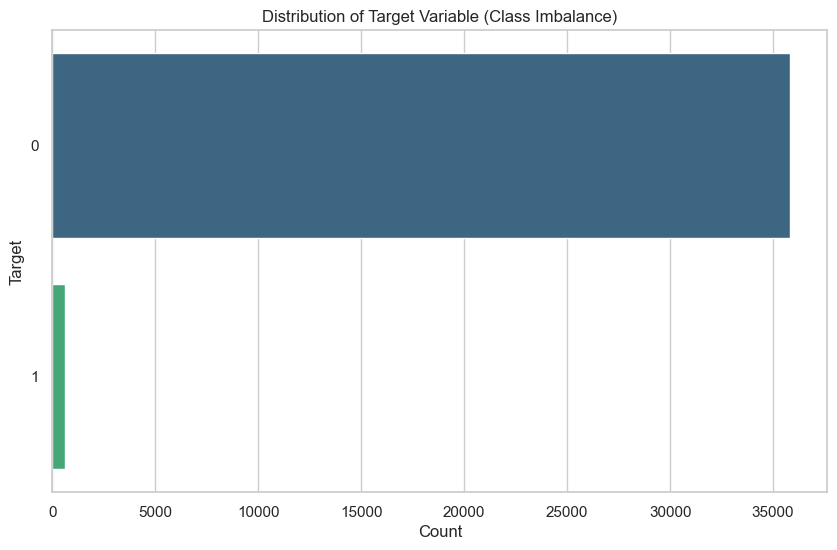

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

X = feature_engineered_data.drop("TARGET", axis=1)
y = feature_engineered_data["TARGET"]

# Set a style for the plots
sns.set(style="whitegrid")

# Visualization 1: Distribution of Target Variable
plt.figure(figsize=(10, 6))
sns.countplot(y=y, palette="viridis")
plt.title("Distribution of Target Variable (Class Imbalance)")
plt.xlabel("Count")
plt.ylabel("Target")
plt.show()

The Distribution of the Target Variable, which highlights the class imbalance in your dataset.

-- The Target variable represents the classification of clients as either 'good'    (likely to meet their credit obligations) or 'bad' (likely to default).

The majority of the clients are classified as '0' (good), which is represented by the large bar.
A much smaller portion of clients are classified as '1' (bad), shown by the smaller bar.

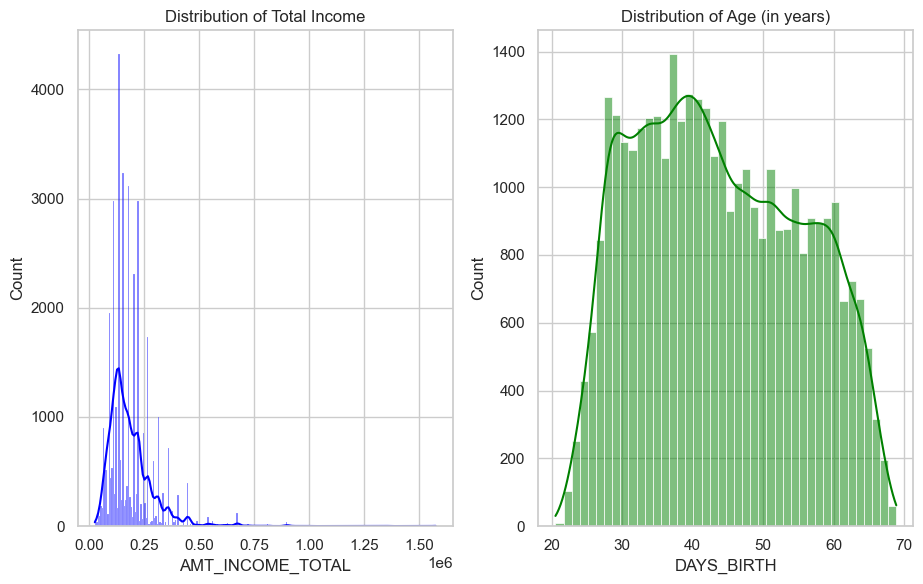

In [5]:
# Plot histograms for key numerical features
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(merged_data["AMT_INCOME_TOTAL"], kde=True, color="blue")
plt.title("Distribution of Total Income")

plt.subplot(1, 3, 2)
sns.histplot(abs(merged_data["DAYS_BIRTH"]) / 365, kde=True, color="green")
plt.title("Distribution of Age (in years)")


plt.tight_layout()
plt.show()

Graph on left displays the distribution of clients' income levels in the dataset.

Understanding the income distribution helps in assessing the financial capacity of the clients. It gives insights into whether the dataset contains more low-income or high-income clients, which could influence creditworthiness.

Graph on right shows the distribution of clients' ages, derived from the DAYS_BIRTH feature (converted to years).

Age can be a critical factor in credit risk assessment. Younger clients might have different spending and repayment behaviors compared to older clients.

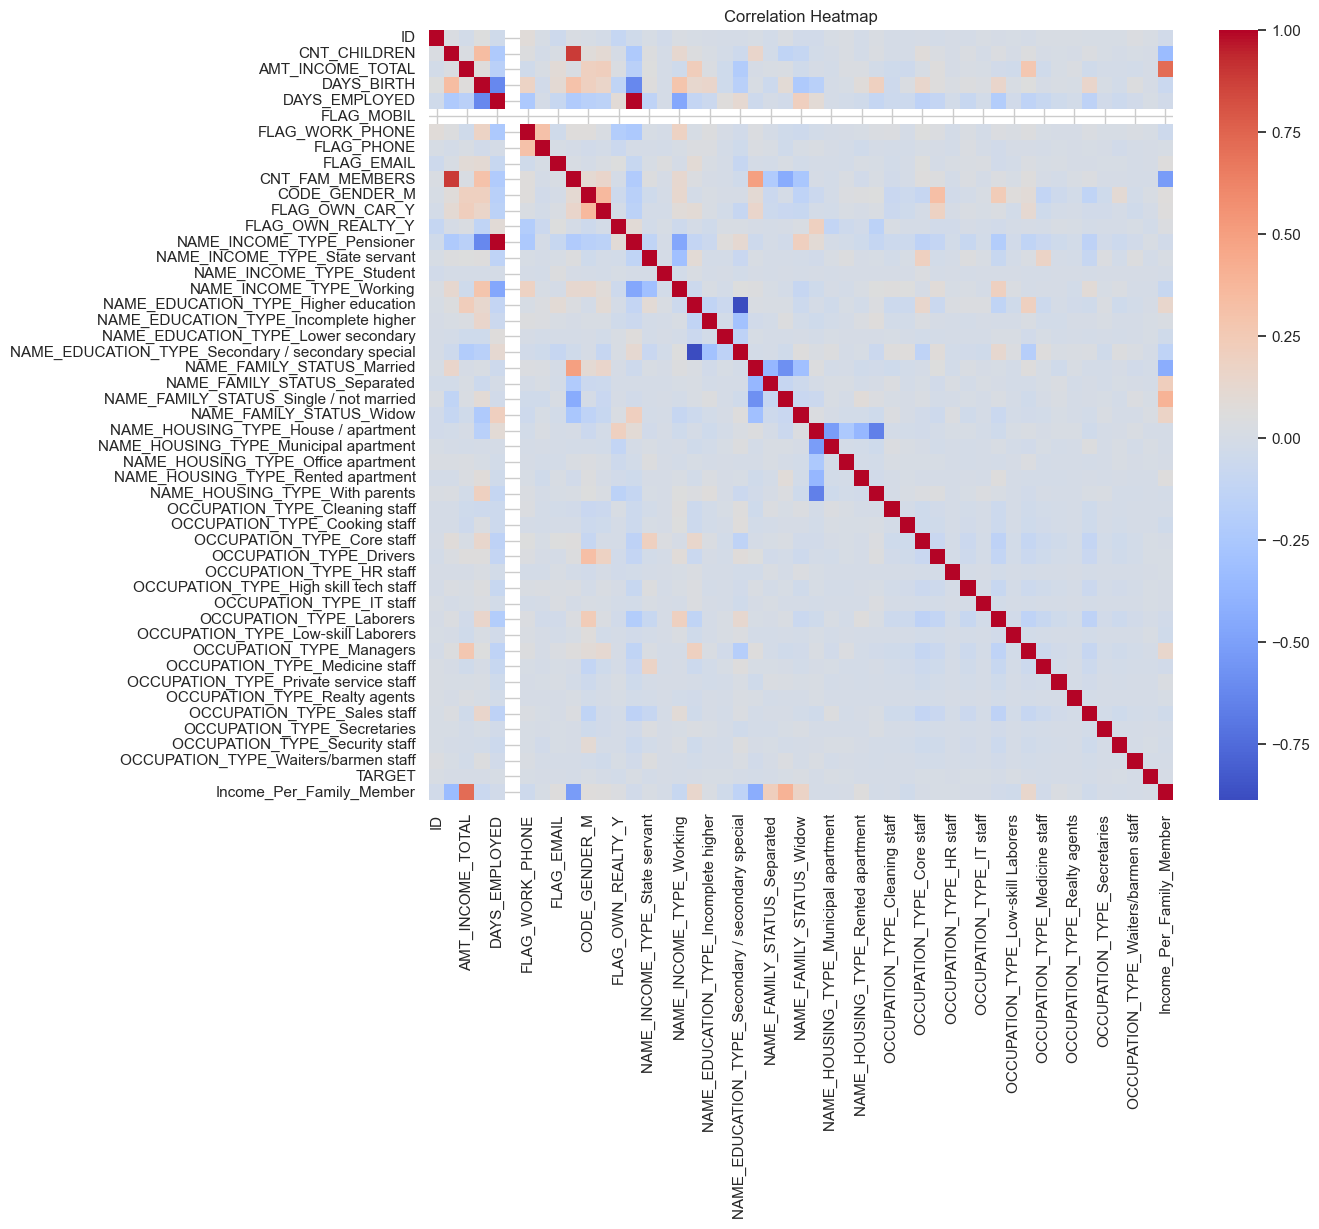

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = feature_engineered_data.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Correlation heatmap visualizes the correlation between different features in the dataset. The color intensity indicates the strength of the correlation, with redder tones showing stronger positive correlations and bluer tones indicating negative correlations.

In [7]:
feature_engineered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 49 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 36457 non-null  int64  
 1   CNT_CHILDREN                                       36457 non-null  int64  
 2   AMT_INCOME_TOTAL                                   36457 non-null  float64
 3   DAYS_BIRTH                                         36457 non-null  int64  
 4   DAYS_EMPLOYED                                      36457 non-null  int64  
 5   FLAG_MOBIL                                         36457 non-null  int64  
 6   FLAG_WORK_PHONE                                    36457 non-null  int64  
 7   FLAG_PHONE                                         36457 non-null  int64  
 8   FLAG_EMAIL                                         36457 non-null  int64  
 9   CNT_FA

       AMT_INCOME_TOTAL
0              427500.0
1              427500.0
2              112500.0
3              270000.0
4              270000.0
...                 ...
36452          315000.0
36453          157500.0
36454          157500.0
36455          283500.0
36456          112500.0

[36457 rows x 1 columns]


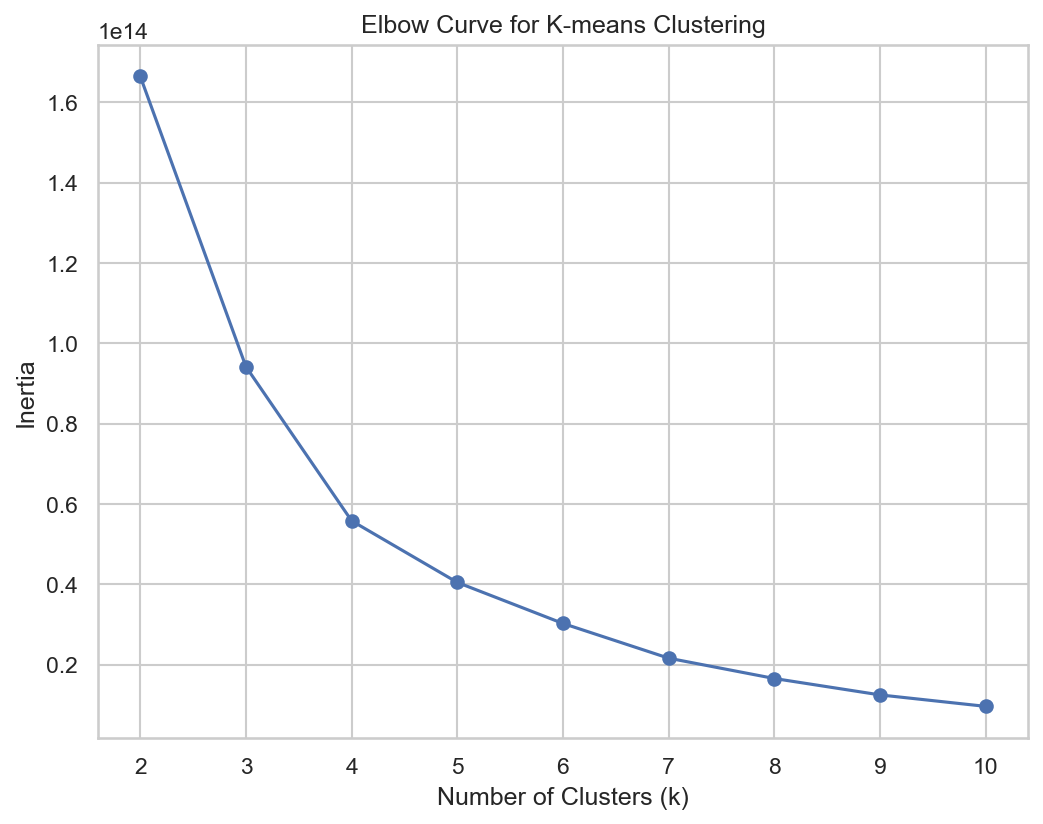

In [8]:
from sklearn.cluster import KMeans

cluster_columns = feature_engineered_data[["AMT_INCOME_TOTAL"]]


print(cluster_columns)

# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(cluster_columns)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Curve for K-means Clustering")
plt.grid(True)
plt.show()

In [9]:
import numpy as np

numeric_columns = feature_engineered_data.select_dtypes(include=[np.number]).columns

categorical_columns = feature_engineered_data.select_dtypes(include=["object"]).columns

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

numeric_transformers = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformers = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformers, numeric_columns),
        ("cat", categorical_transformers, categorical_columns),
    ]
)

# Create a pipeline that includes preprocessing and clustering
kmeans_pipeline = Pipeline(
    [("preprocessor", preprocessor), ("kmeans", KMeans(n_clusters=4, random_state=42))]
)

In [11]:
# Fit the pipeline to the data
kmeans_pipeline.fit(feature_engineered_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'TARGET', 'Income_Per_Family_Member'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [12]:
# Get cluster labels
cluster_labels = kmeans_pipeline.named_steps["kmeans"].labels_

# Add cluster labels to the dataframe
feature_engineered_data["Cluster"] = cluster_labels

feature_engineered_data.head(5)

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,TARGET,Income_Per_Family_Member,Cluster
0,5008804,0,427500.0,-12005,-4542,1,1,0,0,2.0,...,False,False,False,False,False,False,False,0,213750.0,2
1,5008805,0,427500.0,-12005,-4542,1,1,0,0,2.0,...,False,False,False,False,False,False,False,0,213750.0,2
2,5008806,0,112500.0,-21474,-1134,1,0,0,0,2.0,...,False,False,False,False,False,True,False,0,56250.0,2
3,5008808,0,270000.0,-19110,-3051,1,0,1,1,1.0,...,False,False,False,True,False,False,False,0,270000.0,3
4,5008809,0,270000.0,-19110,-3051,1,0,1,1,1.0,...,False,False,False,True,False,False,False,0,270000.0,3


In [13]:
# Perform PCA on the preprocessed data for visualization
pca = PCA(n_components=2)
preprocessed_data = kmeans_pipeline.named_steps["preprocessor"].transform(
    feature_engineered_data
)
pca_features = pca.fit_transform(preprocessed_data)


# Create a dataframe with PCA features
pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2"])
pca_df["Cluster"] = cluster_labels

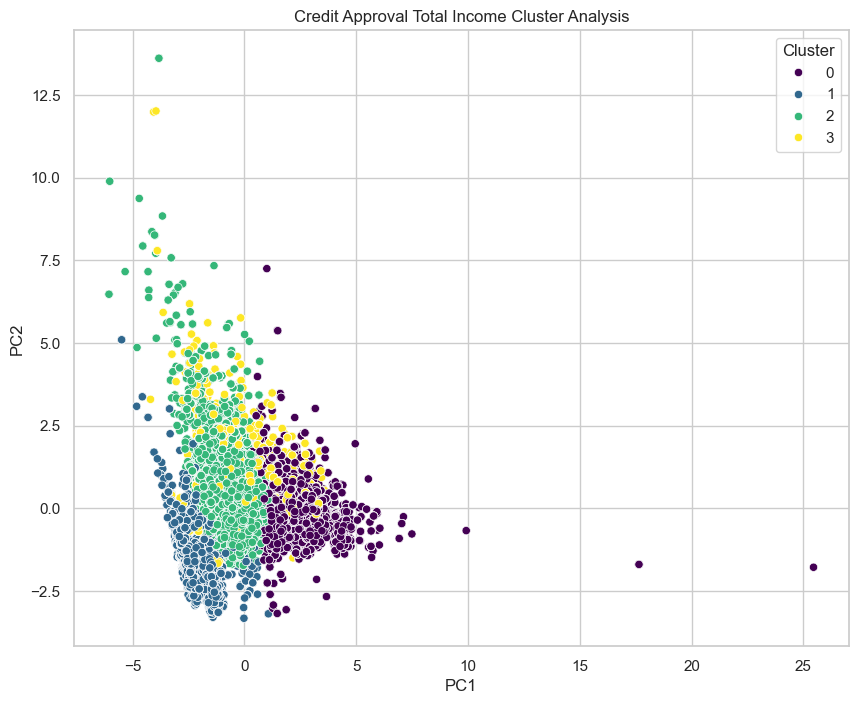

In [14]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="viridis")
plt.title("Credit Approval Total Income Cluster Analysis")
plt.show()

In [15]:
# Analyze cluster characteristics
print("Numeric feature means for each cluster:")
print(feature_engineered_data.groupby("Cluster")[numeric_columns].mean())

Numeric feature means for each cluster:
                   ID  CNT_CHILDREN  AMT_INCOME_TOTAL    DAYS_BIRTH  \
Cluster                                                               
0        5.080982e+06      1.463360     184067.962125 -13359.085176   
1        5.074717e+06      0.026544     147375.673047 -21877.151438   
2        5.079060e+06      0.058066     195292.281888 -15620.829482   
3        5.072172e+06      0.444828     216564.070063 -14462.307524   

         DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
Cluster                                                                       
0           820.305690         1.0         0.276400    0.278869    0.004152   
1        365243.000000         1.0         0.000000    0.291986    0.007487   
2         -2614.429731         1.0         0.279994    0.300233    0.000000   
3         17247.032602         1.0         0.183386    0.313166    1.000000   

         CNT_FAM_MEMBERS    TARGET  Income_Per_Family_Memb

In [16]:
cluster_summary = (
    feature_engineered_data.groupby("Cluster")
    .agg({"AMT_INCOME_TOTAL": "mean", "DAYS_BIRTH": "mean", "DAYS_EMPLOYED": "mean"})
    .reset_index()
)

In [17]:
cluster_summary

,Cluster,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,0,184067.962125,-13359.085176,820.305690
1,1,147375.673047,-21877.151438,365243.000000
2,2,195292.281888,-15620.829482,-2614.429731
3,3,216564.070063,-14462.307524,17247.032602


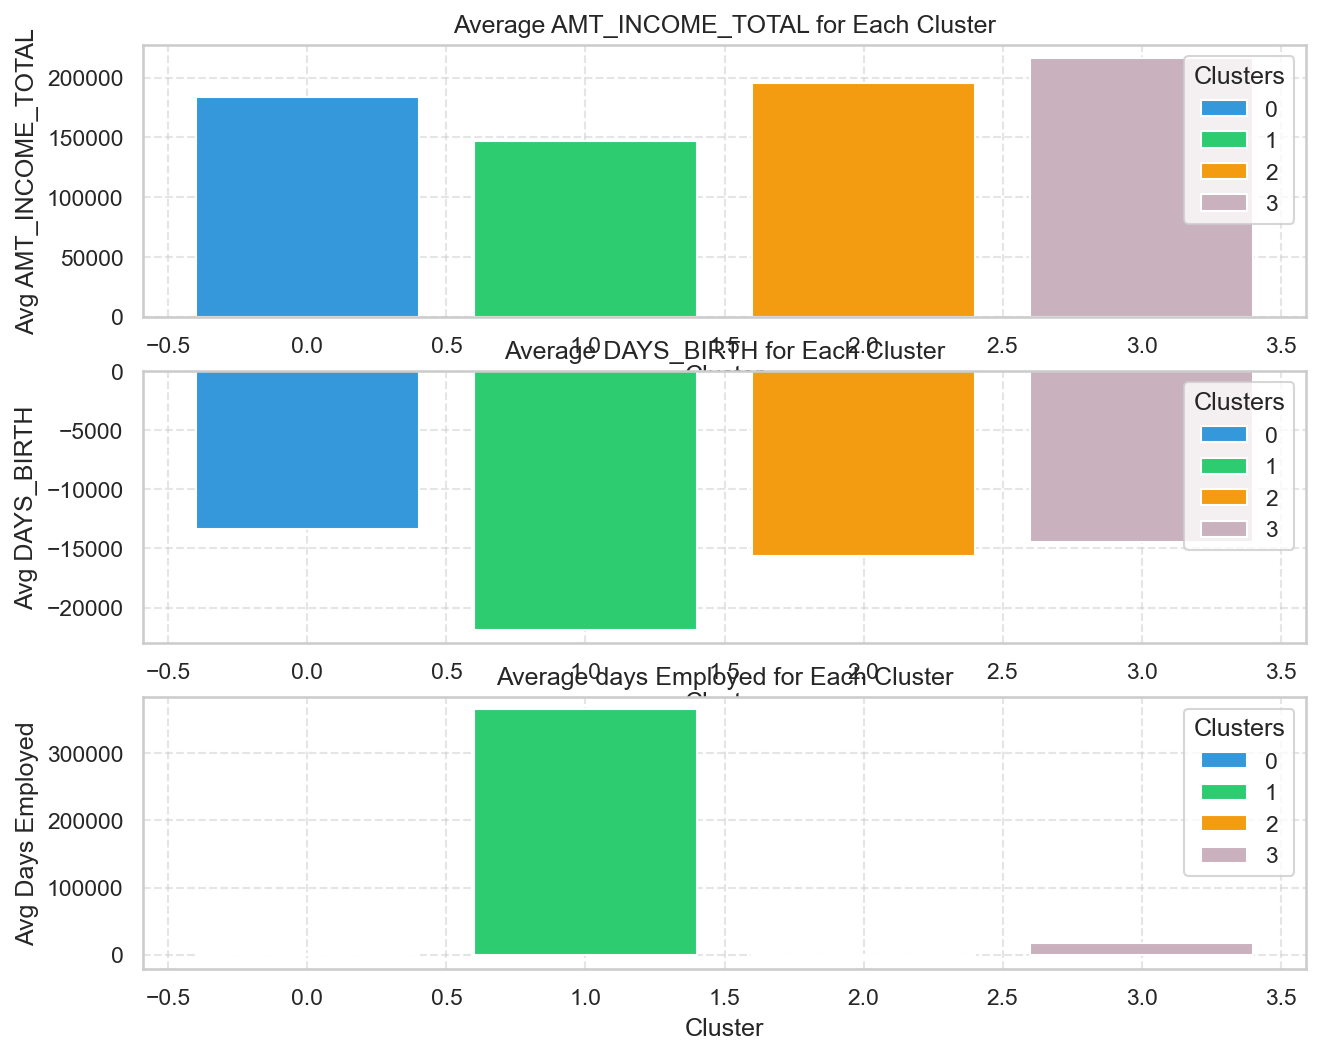

In [18]:
colors = ["#3498db", "#2ecc71", "#f39c12", "#C9B1BD"]

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8), dpi=150)

# Plot Avg Annual Income
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary["AMT_INCOME_TOTAL"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Avg AMT_INCOME_TOTAL")
plt.title("Average AMT_INCOME_TOTAL for Each Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")


# Plot Avg days Birth
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary["DAYS_BIRTH"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Avg DAYS_BIRTH")
plt.title("Average DAYS_BIRTH for Each Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")


# Plot Avg Days employed
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary["DAYS_EMPLOYED"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Avg Days Employed")
plt.title("Average days Employed for Each Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")

## Model Training: Random Forest Classifier
The Random Forest Classifier is chosen for its robustness and ability to handle imbalanced datasets.  Random Forests work by generating multiple decision trees and averaging their outputs. This ensemble method reduces overfitting by relying on a collection of weaker models that, when combined, lead to stronger predictive performance. This model will be trained on the feature-engineered data to predict whether a client is a 'good' or 'bad' credit risk.

In [19]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load feature engineered data
feature_engineered_data = pd.read_csv("../data/processed/feature_engineered_data.csv")

# Ensure 'TARGET' column is present
if "TARGET" not in feature_engineered_data.columns:
    raise KeyError("'TARGET' column not found in the dataset")


# Train model function
def train_model(feature_engineered_data):
    X = feature_engineered_data.drop("TARGET", axis=1)
    y = feature_engineered_data["TARGET"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Random Forest Accuracy:", accuracy)
    print(
        "Random Forest Classification Report:\n", classification_report(y_test, y_pred)
    )

    # Save the model
    joblib.dump(model, "../project2/models/credit_approval_rf_model.pkl")


# Train the model
train_model(feature_engineered_data)

Random Forest Accuracy: 0.9787438288535382
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7175
           1       0.29      0.22      0.25       117

    accuracy                           0.98      7292
   macro avg       0.64      0.61      0.62      7292
weighted avg       0.98      0.98      0.98      7292



In [20]:
import joblib

model = joblib.load("./models/credit_approval_rf_model.pkl")

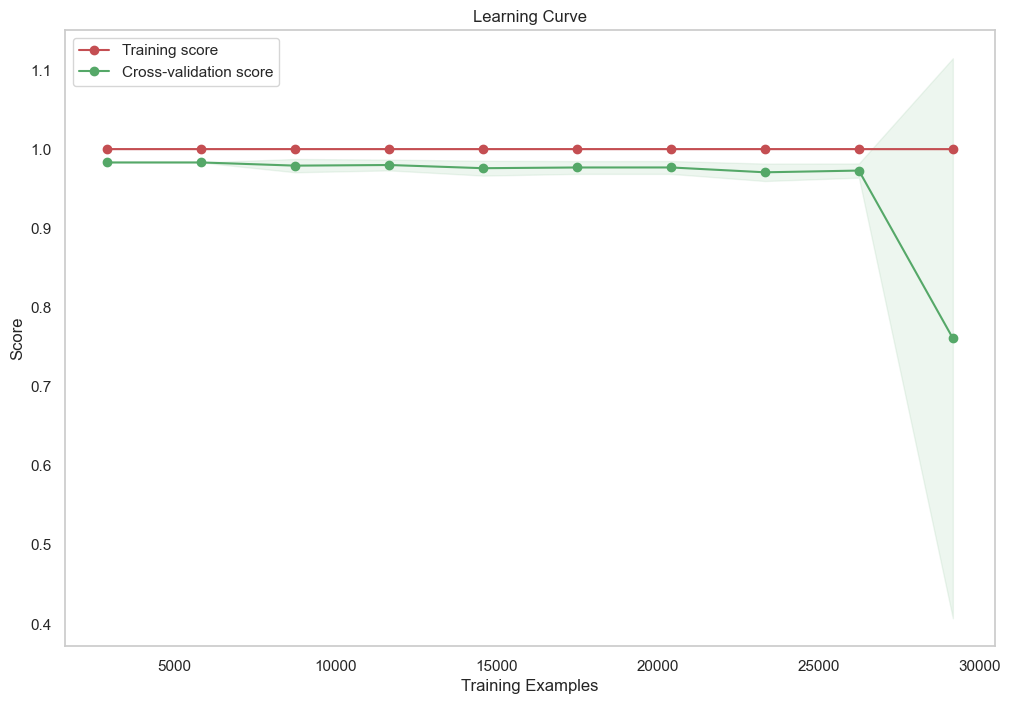

In [21]:
from sklearn.model_selection import learning_curve
import numpy as np


# Function to plot learning curve
def plot_learning_curve(
    estimator,
    X,
    y,
    cv=5,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
):
    plt.figure(figsize=(12, 8))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


# Plot the learning curve for Random Forest model
plot_learning_curve(model, X, y)

Both the training score (red line) and the cross-validation score (green line) start very high, close to 1.0 (100% accuracy). This indicates that the model is initially perfrmoing very well on both the training data and the validation data.

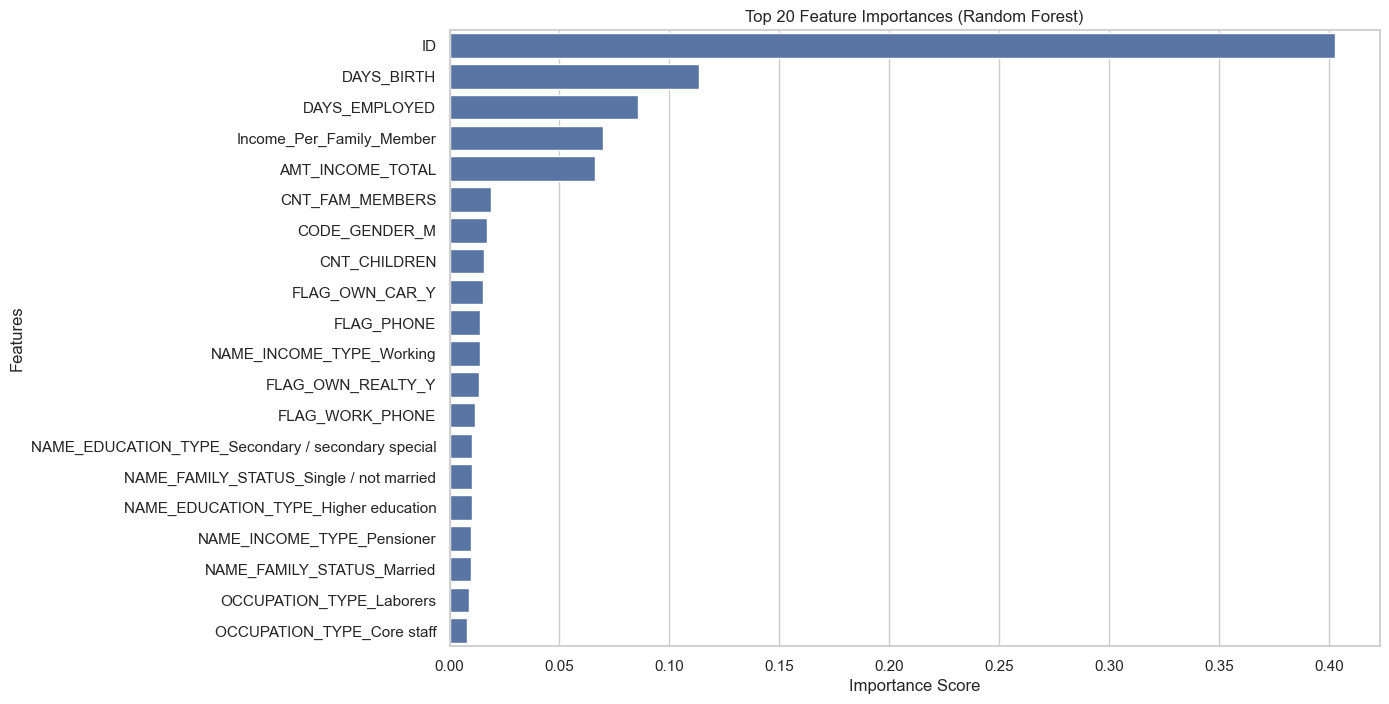

In [22]:
# Load the trained Random Forest model
import joblib

model = joblib.load("./models/credit_approval_rf_model.pkl")

X = feature_engineered_data.drop("TARGET", axis=1)
y = feature_engineered_data["TARGET"]

# Feature importance plot
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

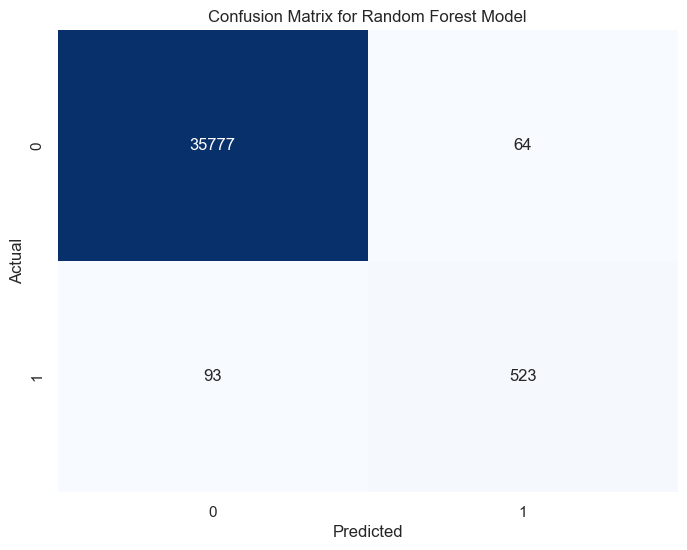

In [23]:
# Generate predictions
y_pred_rf = model.predict(X)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion matrix shown above illustrates the performance of the Random Forest model in classifying the test data into two categories: '0' (negative class, likely 'good' credit risk) and '1' (positive class, likely 'bad' credit risk).

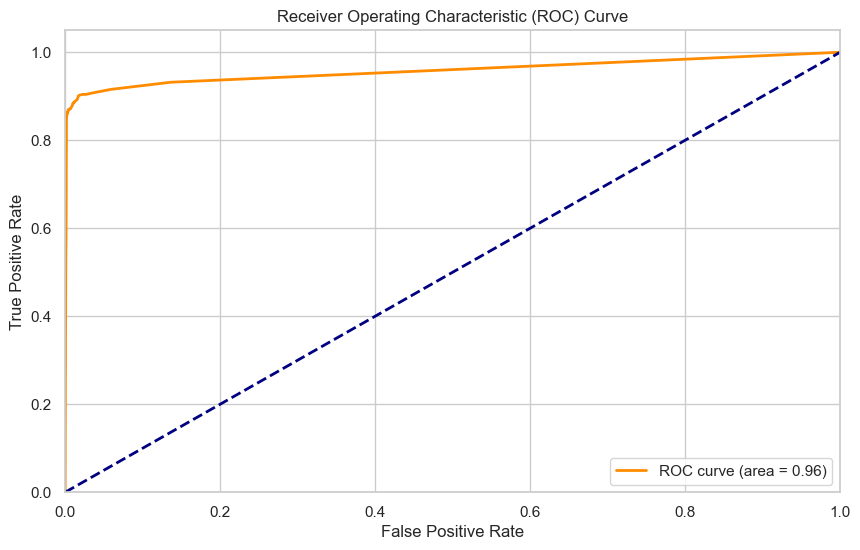

In [24]:
# Compute ROC curve and ROC area for Random Forest
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

AUC  is very high and indicates that the model is performing exceptionally well at distinguishing between the two classes (e.g., 'good' vs. 'bad' clients).

The model is highly effective in distinguishing between clients who are likely to meet their credit obligations ('good' clients) and those who are at risk of defaulting ('bad' clients). This high AUC value indicates that the model is very reliable in its predictions.

The Random Forest model provides a high accuracy of 97.87%, which indicates that it performs well in predicting 'good' clients. However, the classification report shows that the model struggles to correctly classify 'bad' clients, primarily due to the class imbalance in the dataset. The model's lower recall and precision for detecting 'bad' clients is concerning for real-world applications, as it may miss identifying high-risk individuals.

For financial institutions, the ability to correctly identify 'bad' clients is as important as identifying 'good' ones. Although the Random Forest model shows high overall accuracy, its lower performance in identifying 'bad' clients suggests that additional measures, such as re-sampling techniques or adjusting the decision threshold, may be necessary to improve the model's effectiveness. A model that consistently misses high-risk clients could lead to increased default rates and financial losses.

## Model Training: Neural Network
A Neural Network model is also trained to explore if a more complex, non-linear model can improve the prediction of 'bad' clients.

In [25]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load feature engineered data
feature_engineered_data = pd.read_csv("../data/processed/feature_engineered_data.csv")

# Prepare the data
X = feature_engineered_data.drop("TARGET", axis=1).astype(np.float32)
y = feature_engineered_data["TARGET"].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Define a simple neural network model
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Build and train the model
model = build_neural_network(X_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print("Neural Network Accuracy:", model.evaluate(X_test, y_test)[1])
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

2024-08-15 22:11:55.580589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 22:11:55.595702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 22:11:55.599792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 22:11:55.611392: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 22:11:56.832827: W tensorflow/compiler/tf2

Epoch 1/10


I0000 00:00:1723774317.954623 2889689 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723774317.961730 2889689 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723774317.967807 2889689 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723774317.970985 2889689 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

196/730 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.9613 - loss: 4095.3569

I0000 00:00:1723774319.709113 2891038 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9631 - loss: 3966.5281 - val_accuracy: 0.9823 - val_loss: 1019.8692
Epoch 2/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.9663 - loss: 3426.7771 - val_accuracy: 0.9823 - val_loss: 1378.5043
Epoch 3/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.9633 - loss: 3165.7026 - val_accuracy: 0.9823 - val_loss: 1484.4819
Epoch 4/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.9671 - loss: 2084.7400 - val_accuracy: 0.9823 - val_loss: 1588.4901
Epoch 5/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.9681 - loss: 1613.7208 - val_accuracy: 0.9823 - val_loss: 355.4807
Epoch 6/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.9650 - loss: 1483.9015 - val_accuracy: 0.9823 - val_loss: 2338.0762
Epoch 7/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.9694 - loss: 1346.1482 - val_accuracy: 0.9823 - val_loss: 912.8891
Epoch 8/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accurac

/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

The Neural Network model achieves a similarly high accuracy to the Random Forest model, indicating that it is also effective in predicting 'good' clients. However, like the Random Forest model, it struggles to accurately identify 'bad' clients, as evidenced by low precision and recall for the 'bad' class. This is a common challenge when dealing with imbalanced datasets, where the model tends to favor the majority class.

While Neural Networks can capture complex relationships in data, their performance in this scenario is similar to the Random Forest model. The challenge of accurately predicting 'bad' clients persists, highlighting the need for further model tuning or alternative approaches. In a business context, relying solely on this model could result in missed opportunities to mitigate risk. Therefore, additional techniques such as cost-sensitive learning or anomaly detection might be explored to enhance the identification of high-risk clients.

In [26]:
# Summary of the analysis
print("Interpreting the Results:")

# Random Forest Model Interpretation
# Here you can discuss feature importances and model performance.
print(
    "Random Forest Model: The Random Forest model achieved a high accuracy, primarily because it correctly classified most 'good' clients. However, its ability to detect 'bad' clients is limited due to the class imbalance."
)

# Neural Network Model Interpretation
# Here you can discuss how the neural network performed and any overfitting signs.
print(
    "Neural Network Model: The Neural Network also achieved high accuracy, but similarly struggled with detecting 'bad' clients. Tuning the model and handling class imbalance could improve its performance."
)

# Conclusion
print(
    "Conclusion: Both models perform well in identifying 'good' clients, but struggle with 'bad' clients due to the imbalance in the dataset. Techniques like SMOTE and further tuning of the models may improve the classification of 'bad' clients."
)

Interpreting the Results:
Random Forest Model: The Random Forest model achieved a high accuracy, primarily because it correctly classified most 'good' clients. However, its ability to detect 'bad' clients is limited due to the class imbalance.
Neural Network Model: The Neural Network also achieved high accuracy, but similarly struggled with detecting 'bad' clients. Tuning the model and handling class imbalance could improve its performance.
Conclusion: Both models perform well in identifying 'good' clients, but struggle with 'bad' clients due to the imbalance in the dataset. Techniques like SMOTE and further tuning of the models may improve the classification of 'bad' clients.


The analysis reveals that while both the Random Forest and Neural Network models perform well overall, they are not particularly effective at identifying 'bad' clients. This limitation is largely due to the imbalanced nature of the dataset, where 'bad' clients represent a small fraction of the total.

For a financial institution, the ability to accurately identify 'bad' clients is crucial for risk management. The current models, while accurate overall, may not sufficiently protect against defaults. This insight underscores the need for model improvements, such as re-sampling techniques (e.g., SMOTE) or the implementation of custom loss functions that penalize false negatives more heavily. By doing so, the institution can better safeguard its financial health while still capitalizing on lending opportunities.

Conclusion
In conclusion, this project highlights the complexities of credit risk modeling, particularly when dealing with imbalanced datasets. Both the Random Forest and Neural Network models demonstrate high accuracy in predicting 'good' clients but fall short in identifying 'bad' clients. This challenge must be addressed to create a robust credit scoring model that accurately reflects the risk profiles of all clients.

## Deeper Dive into Customer Data: Understanding Customer Attrition

Determining whether a customer is "good" or "bad" involves analyzing their behavior over a period of time.  
A "good" customer tends to exhibit more responsible financial behavior, such as maintaining savings to ensure timely payments even in unforeseen circumstances. 

However, a crucial question arises: **How long does it take for a customer to transition into the "bad" category?**

### Analyzing the Relationship Between Customer Tenure and Attrition Rate 

Let's explore how the percentage of customers classified as "bad" varies depending on how long they have been with the company. 


In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import warnings

warnings.filterwarnings("ignore")

from IPython.display import Markdown
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

custom_params = {
    "grid.color": ".94",
    # "figure.facecolor": "#FBFBFB",
    # "axes.facecolor": "#FBFBFB",
    "axes.spines.right": False,
    "axes.spines.top": False,
}

sns.set_theme(style="whitegrid", rc=custom_params)
# sns.set_palette("husl")
sns.set_palette("coolwarm")


In [28]:
# Let's check the percentage of bad clients by how long they have been clients
# Load and preprocess data
application_df, credit_df = load_data()

# Convert categorical columns to numeric using one-hot encoding
categorical_cols = [
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
]

# Merge datasets on ID column
merged_data = pd.merge(application_df, credit_df, on="ID", how="inner")

Here, we are transforming the table so it represents the client history, where each row corresponds to a client and each column corresponds to a month.

The values in the table represent the client's credit status for that month.  
This transformation allows us to analyze how the percentage of 'bad' clients changes over time, providing insights into client behavior and credit risk trends.

In [29]:
grouped_credit = credit_df.groupby("ID")
client_lifetime = credit_df[["ID", "MONTHS_BALANCE", "STATUS"]]

wide_credit_table = client_lifetime.pivot(
    index="ID", columns="MONTHS_BALANCE", values="STATUS"
)
wide_credit_table["OPEN_MONTH"] = grouped_credit[
    "MONTHS_BALANCE"
].min()  # smallest value of MONTHS_BALANCE, is the month when loan was granted
wide_credit_table["END_MONTH"] = grouped_credit[
    "MONTHS_BALANCE"
].max()  # biggest value of MONTHS_BALANCE, end of observe window or end of loan
wide_credit_table["TIME_WINDOW"] = (
    wide_credit_table["END_MONTH"] - wide_credit_table["OPEN_MONTH"]
)  # calculate observe `window` of each ID
wide_credit_table["ID"] = wide_credit_table.index
wide_credit_table.columns = wide_credit_table.columns.astype(str)
wide_credit_table.reset_index(drop=True, inplace=True)
wide_credit_table.head(5).style.set_caption("Wide Credit Table")

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,OPEN_MONTH,END_MONTH,TIME_WINDOW,ID
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,X,-3,0,3,5001711
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,C,C,C,C,C,C,C,C,C,-18,0,18,5001712
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-21,0,21,5001713
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-14,0,14,5001714
4,nan,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,-59,0,59,5001715


In [30]:
# Shift the columns to have the END_MONTH all aligned at the last column [0]
# This will allow us to track the status of the client over time

aligned_monthly_data = wide_credit_table.copy()
aligned_monthly_data.drop(["OPEN_MONTH", "TIME_WINDOW", "ID"], axis=1, inplace=True)

# open_months = aligned_monthly_data["OPEN_MONTH"].values
end_months = aligned_monthly_data["END_MONTH"].values

# Calculate the shift amounts
shift_amounts = end_months * -1

# Drop END_MONTH from the DataFrame for processing
df_values = aligned_monthly_data.drop(columns="END_MONTH").values

# Create an empty array for the aligned values
aligned_values = np.empty_like(df_values, dtype=object)
aligned_values.fill(np.nan)

# Perform the shift operation using numpy
for i, shift in enumerate(shift_amounts):
    if shift > 0:
        aligned_values[i, shift:] = df_values[i, :-shift]
    elif shift < 0:
        aligned_values[i, :shift] = df_values[i, -shift:]
    else:
        aligned_values[i] = df_values[i]

# Rebuild the DataFrame
aligned_monthly_data = pd.DataFrame(
    aligned_values, columns=[str(i) for i in range(-60, 1)]
)
aligned_monthly_data.insert(0, "OPEN_MONTH", wide_credit_table["OPEN_MONTH"])
aligned_monthly_data.insert(0, "TIME_WINDOW", wide_credit_table["TIME_WINDOW"])

# Replace the status values with numeric values
aligned_monthly_data.replace({"C": -1, "X": -1}, inplace=True)
aligned_monthly_data = aligned_monthly_data.apply(pd.to_numeric, errors="coerce")
aligned_monthly_data[0:-10]

,TIME_WINDOW,OPEN_MONTH,-60,-59,-58,-57,-56,-55,-54,-53,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
0,3,-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1
1,18,-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
2,21,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
3,14,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
4,59,-59,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45970,6,-52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-1
45971,5,-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0
45972,34,-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
45973,43,-43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1


### Cumulative Count of Bad Clients Over Time

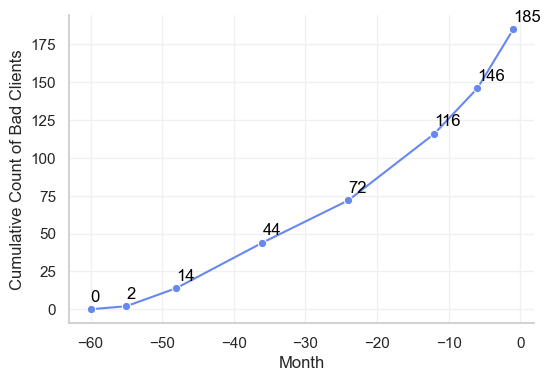

In [31]:
# Count the number of bad clients (values > 3) for each client cumulatively
time_points = [-60, -55, -48, -36, -24, -12, -6, -1]

filtered_df = aligned_monthly_data[
    ["OPEN_MONTH"] + [str(month) for month in time_points]
]

cumulative_results = {}

BAD_CLIENT = 2  # Clients with status 2, 3, 4, or 5 are considered bad

for month in time_points:
    # Select all columns from OPEN_MONTH to the current month
    cumulative_df = filtered_df.loc[:, "OPEN_MONTH" : str(month)]
    cumulative_bad_clients = (cumulative_df > BAD_CLIENT).sum(axis=1)
    cumulative_count = (cumulative_bad_clients > 0).sum()
    cumulative_results[month] = cumulative_count

cumulative_results_df = pd.DataFrame(
    list(cumulative_results.items()),
    columns=["Month", "Cumulative Count of Bad Clients"],
)

plt.figure(figsize=(6, 4))
ax = sns.lineplot(
    x="Month",
    y="Cumulative Count of Bad Clients",
    data=cumulative_results_df,
    marker="o",
)

# Add numbers on top of the bars
for index, row in cumulative_results_df.iterrows():
    ax.text(
        row["Month"],
        row["Cumulative Count of Bad Clients"] + 5,  # Slightly above the bar
        f'{row["Cumulative Count of Bad Clients"]}',
        color="black",
    )

plt.xlabel("Month")
plt.ylabel("Cumulative Count of Bad Clients")
sns.despine(top=True, right=True)
plt.show()

### Client Payment History Analysis

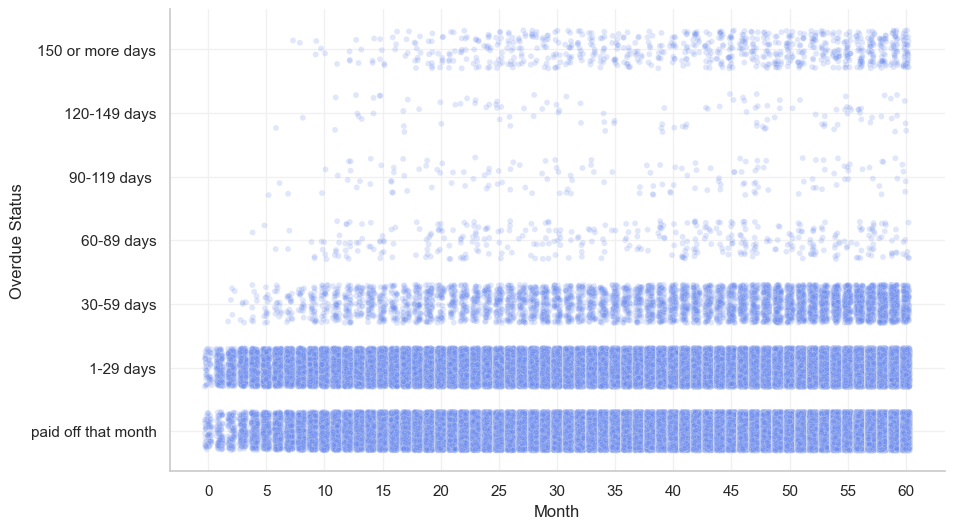

In [32]:
client_sample = aligned_monthly_data.sample(20000, random_state=200)
client_sample.sort_values("TIME_WINDOW", inplace=True, ascending=True)
client_sample = client_sample.drop(["OPEN_MONTH", "TIME_WINDOW"], axis=1)

plot_data = client_sample.reset_index().melt(
    id_vars=["index"], var_name="Month", value_name="Value"
)
plot_data["Month"] = plot_data["Month"].astype(int)

# Add jitter to the Month values to avoid stacking
jitter_1 = np.random.uniform(-0.3, 0.3, size=plot_data.shape[0])
jitter_2 = np.random.uniform(-0.3, 0.3, size=plot_data.shape[0])

plot_data["Value"] = plot_data["Value"] + jitter_1
plot_data["Month"] = plot_data["Month"] + jitter_2

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_data,
    x="Month",
    y="Value",
    legend=None,
    alpha=0.2,
    size=0.1,
)

y_labels_map = {
    -1: "paid off that month",
    0: "1-29 days",
    1: "30-59 days",
    2: "60-89 days",
    3: "90-119 days ",
    4: "120-149 days",
    5: "150 or more days",
}

y_ticks = list(y_labels_map.keys())
y_labels = list(y_labels_map.values())
plt.yticks(ticks=y_ticks, labels=y_labels)
current_ticks = np.arange(-60, 1, 5)  # Current tick positions
new_labels = np.arange(0, 61, 5)  # New labels from 0 to 60
plt.xticks(ticks=current_ticks, labels=new_labels)

plt.xlabel("Month")
plt.ylabel("Overdue Status")
sns.despine(top=True, right=True)
plt.show()

### Random sample of 200 individual clients payment history over time

The graph below provides a visual representation of how the credit status of individual clients evolves over time.

By observing the payment patterns of these clients, we can identify trends and patterns that may indicate credit risk.  
For example, clients who consistently have overdue payments or a high proportion of 'bad' months may be considered higher risk.

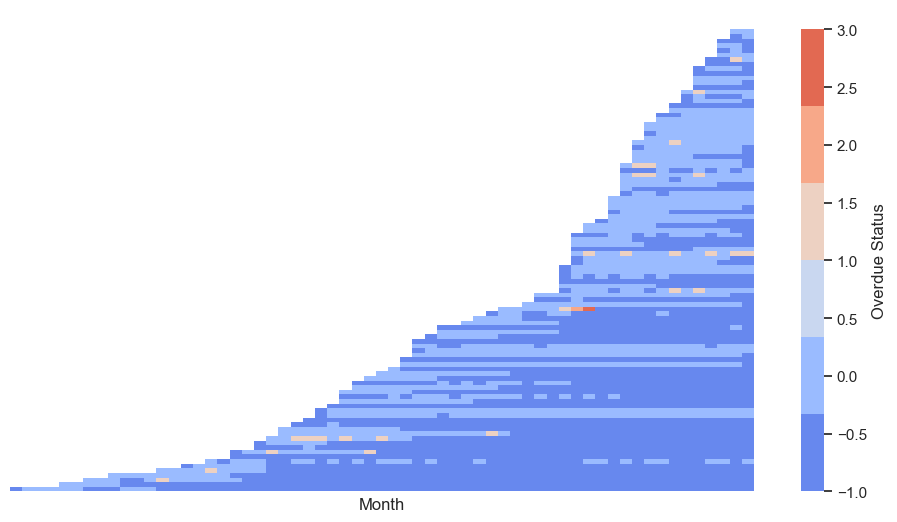

In [33]:
client_sample = aligned_monthly_data.sample(100, random_state=13)
client_sample.sort_values("TIME_WINDOW", inplace=True, ascending=True)
plt.figure(figsize=(12, 6))

ax = sns.heatmap(
    client_sample.drop(["OPEN_MONTH", "TIME_WINDOW"], axis=1),
    cbar_kws={"label": "Overdue Status"},
    linewidths=0,
    cmap=sns.color_palette("coolwarm", as_cmap=False, n_colors=6),
    xticklabels=False,
    yticklabels=False,
)

plt.xlabel("Month")
plt.title(" ")
plt.show()

## Vintage Analysis

The vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted.

In [34]:
# Making sure the data is correctly loaded
application_df, credit_df = load_data()

# Creates a new DataFrame with the "OPEN_MONTH", "END_MONTH" and "WINDOW" columns
grouped = credit_df.groupby("ID")
pivot_tb = credit_df.pivot(index="ID", columns="MONTHS_BALANCE", values="STATUS")
pivot_tb["OPEN_MONTH"] = grouped["MONTHS_BALANCE"].min()
pivot_tb["END_MONTH"] = grouped["MONTHS_BALANCE"].max()
pivot_tb["ID"] = pivot_tb.index
pivot_tb = pivot_tb[["ID", "OPEN_MONTH", "END_MONTH"]]
pivot_tb["TIME_WINDOW"] = pivot_tb["END_MONTH"] - pivot_tb["OPEN_MONTH"]
pivot_tb.reset_index(drop=True, inplace=True)
pivot_tb

MONTHS_BALANCE,ID,OPEN_MONTH,END_MONTH,TIME_WINDOW
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [35]:
# Joining "OPEN_MONTH", "END_MONTH", "WINDOW" to the credit table
credit = pd.merge(credit_df, pivot_tb, on="ID", how="left")

# Create a new column to indicate whether the loan is default
credit["60_DAYS_DUE"] = np.where(
    (credit["STATUS"] == "2")
    | (credit["STATUS"] == "3")
    | (credit["STATUS"] == "4")
    | (credit["STATUS"] == "5"),
    1,
    0,
)  # analyze > 60 days past due
credit["60_DAYS_DUE"] = credit["60_DAYS_DUE"].astype(np.int8)  # 1: overdue 0: not

credit["MONTH_ON_BOOK"] = (
    credit["MONTHS_BALANCE"] - credit["OPEN_MONTH"]
)  # calculate month on book: how many months after opening account
credit.sort_values(by=["ID", "MONTH_ON_BOOK"], inplace=True)

# denominator
denominator = pivot_tb.groupby(["OPEN_MONTH"]).agg(
    {"ID": ["count"]}
)  # count how many users in every month the account was opened
denominator.reset_index(inplace=True)
denominator.columns = ["OPEN_MONTH", "STA_SUM"]

In [36]:
# Vintage table
vintage = credit.groupby(["OPEN_MONTH", "MONTH_ON_BOOK"]).agg({"ID": ["count"]})
vintage.reset_index(inplace=True)
vintage.columns = ["OPEN_MONTH", "MONTH_ON_BOOK", "STA_SUM"]
vintage["DUE_COUNT"] = np.nan
vintage = vintage[["OPEN_MONTH", "MONTH_ON_BOOK", "DUE_COUNT"]]  # delete STA_SUM column
vintage = pd.merge(
    vintage, denominator, on=["OPEN_MONTH"], how="left"
)  # join STA_SUM colun to vintage table

In [37]:
vintage = vintage.copy()

for j in range(-60, 1):  # outer loop: month in which account was opened
    ls = []
    for i in range(0, 61):  # inner loop time after the credit card was granted
        due = list(
            credit[
                (credit["60_DAYS_DUE"] == 1)
                & (credit["MONTH_ON_BOOK"] == i)
                & (credit["OPEN_MONTH"] == j)
            ]["ID"]
        )  # get ID which satisfy the condition
        ls.extend(due)  # As time goes, add bad customers
        vintage.loc[
            (vintage["MONTH_ON_BOOK"] == i) & (vintage["OPEN_MONTH"] == j), "DUE_COUNT"
        ] = len(
            set(ls)
        )  # calculate non-duplicate ID numbers using set()

vintage["DUE_COUNT"] = vintage["DUE_COUNT"]
vintage["STA_RATE"] = (
    vintage["DUE_COUNT"] / vintage["STA_SUM"]
)  # calculate cumulative % of bad customers
vintage["STA_RATE"] = vintage["STA_RATE"].fillna(0)  # fill NA with 0
vintage.head(10)

,OPEN_MONTH,MONTH_ON_BOOK,DUE_COUNT,STA_SUM,STA_RATE
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
5,-60,5,1.0,415,0.002410
6,-60,6,1.0,415,0.002410
7,-60,7,3.0,415,0.007229
8,-60,8,3.0,415,0.007229
9,-60,9,4.0,415,0.009639


In [38]:
# Vintage wide table
vintage_wide = vintage.copy()
vintage_wide["CUM_SUM"] = (
    vintage_wide["STA_SUM"].groupby(vintage_wide["OPEN_MONTH"]).cumsum()
)  # calculate cumulative number of accounts opened
vintage_wide["STA_RATE_PER"] = vintage_wide["STA_RATE"] * 100
vintage_wide = vintage_wide.pivot(
    index="OPEN_MONTH", columns="MONTH_ON_BOOK", values="STA_RATE_PER"
)
vintage_wide.style.format("{:.2f}").set_caption(
    "Vintage analysis table: Cumulative % of Bad Customers by Vintage Cohort"
)
# vintage_wide.style.bar(axis=0, color='#d65f5f').format("{:.3f}")

MONTH_ON_BOOK,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
OPEN_MONTH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00,0.00,0.00,0.00,0.00,0.24,0.24,0.72,0.72,0.96,0.96,1.20,1.45,1.69,1.69,1.69,1.69,1.69,1.69,1.69,1.69,1.93,1.93,1.93,1.93,2.17,2.17,2.17,2.17,2.41,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.89,2.89,2.89,2.89,2.89,2.89,2.89,2.89,3.13,3.13,3.13
-59,0.00,0.00,0.00,0.49,0.49,0.49,0.74,0.74,0.74,1.23,1.23,1.97,1.97,1.97,1.97,1.97,1.97,1.97,2.22,2.46,2.46,2.71,2.71,2.71,2.71,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,3.20,3.20,3.20,3.20,3.20,3.20,nan
-58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.68,0.68,1.14,1.36,1.36,1.36,1.36,1.36,1.36,1.59,1.82,1.82,1.82,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,nan,nan
-57,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.75,0.75,0.75,0.75,0.75,1.00,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.25,2.25,2.25,2.25,2.25,2.25,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,nan,nan,nan
-56,0.00,0.00,0.43,0.43,0.85,1.06,1.06,1.70,1.70,2.13,2.13,2.55,2.98,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.62,3.62,3.62,3.62,3.83,3.83,nan,nan,nan,nan
-55,0.00,0.00,0.41,0.82,1.44,1.85,2.47,2.47,2.47,2.67,2.67,2.67,2.88,3.50,3.70,3.91,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.32,4.32,4.32,4.32,4.32,4.32,4.32,4.53,4.53,4.53,4.53,4.53,4.53,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,nan,nan,nan,nan,nan
-54,0.00,0.00,0.00,0.21,0.43,0.43,0.64,1.28,1.28,1.71,1.92,1.92,2.35,2.78,2.78,2.99,2.99,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,nan,nan,nan,nan,nan,nan
-53,0.00,0.41,0.61,0.61,0.81,0.81,1.22,1.42,1.42,1.62,1.83,1.83,1.83,1.83,1.83,1.83,1.83,1.83,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.43,2.43,2.43,2.43,2.43,2.43,2.43,2.43,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,3.04,3.25,3.25,3.25,3.25,3.25,3.25,nan,nan,nan,nan,nan,nan,nan
-52,0.00,0.00,0.72,0.90,0.90,0.90,1.27,1.27,1.45,1.63,1.63,1.63,1.81,1.81,1.81,1.99,1.99,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,nan,nan,nan,nan,nan,nan,nan,nan


The rows represent months of opening accounts, columns represent months after openning acounts, and values are accumlate past-due rate. As open-month closes to 0, the observe window shortens, thus the bottom half triangular field is filled by nan.

### Cumulative % of Bad Customers (> 60 Days Past Due)

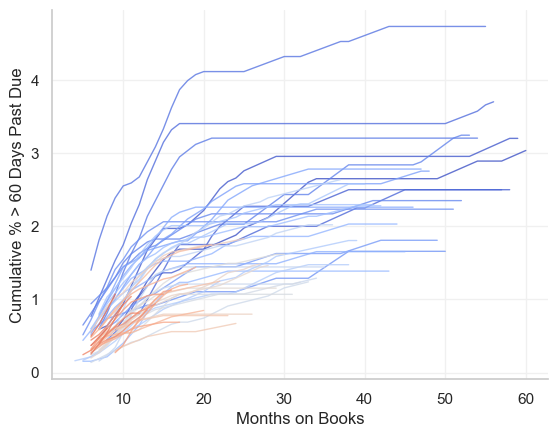

In [39]:
# plot vintage line chart
vintage_tmp = vintage_wide.copy()
vintage_tmp = vintage_tmp.replace(0, np.nan)
sns.lineplot(
    data=vintage_tmp.T.rolling(window=5).mean(),
    legend=False,
    linewidth=1,
    palette="coolwarm",
    dashes=False,
    alpha=0.8,
)
plt.xlabel("Months on Books")
plt.ylabel("Cumulative % > 60 Days Past Due")
plt.grid(True)
plt.show()

Analysing the graph above, we notice the number of customers with past due accounts increasing up to a certain time window, around **24 months**.

Given this insight, financial institutions can adjust their risk management strategies to account for the higher risk of default within the first two years of a client's relationship. This could involve implementing stricter credit checks, setting lower credit limits, or offering more tailored financial products to mitigate the risk of default.

# Observe Window Analysis

Our accounts data is cut short due to account cancellations and the end of observation periods. The observation window is an important factor to consider. If the window is too short, we might miss out on important user behaviors, leading to noise in our data.

To see how the number of accounts changes as we extend the observation window, we created a plot.

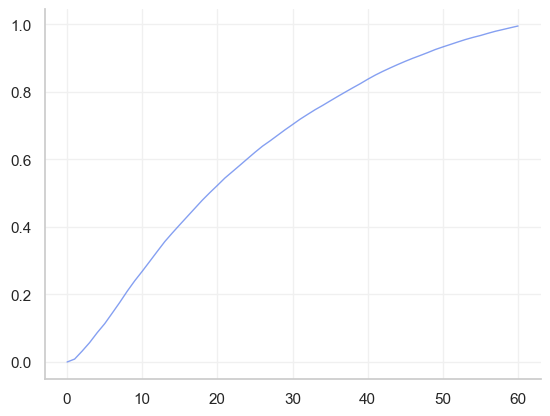

In [40]:
lst = []
for i in range(0, 61):
    ratio = len(pivot_tb[pivot_tb["TIME_WINDOW"] < i]) / len(set(pivot_tb["ID"]))
    lst.append(ratio)

ax = sns.lineplot(pd.Series(lst), linewidth=1, dashes=False, alpha=0.8)

We could see that a 60 months observe window covers all appliers, while **20 months** window contains about **52% of the total records**.

In [41]:
credit_bkp = credit.copy()

In [42]:
credit = credit_bkp.copy()


def calculate_observe(credit, command):
    """calculate observe window"""
    id_sum = len(set(pivot_tb["ID"]))
    credit["status"] = 0
    exec(command)
    # credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit["month_on_book"] = credit["MONTHS_BALANCE"] - credit["OPEN_MONTH"]
    minagg = credit[credit["status"] == 1].groupby("ID")["month_on_book"].min()
    minagg = pd.DataFrame(minagg)
    minagg["ID"] = minagg.index
    obslst = pd.DataFrame({"month_on_book": range(0, 61), "rate": None})
    lst = []
    for i in range(0, 61):
        due = list(minagg[minagg["month_on_book"] == i]["ID"])
        lst.extend(due)
        obslst.loc[obslst["month_on_book"] == i, "rate"] = len(set(lst)) / id_sum
    return obslst["rate"]


command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = (
    "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
)
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

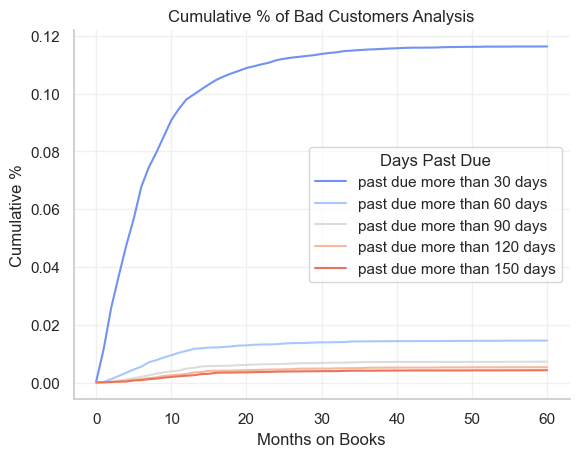

In [43]:
obslst = pd.DataFrame(
    {
        "past due more than 30 days": morethan30,
        "past due more than 60 days": morethan60,
        "past due more than 90 days": morethan90,
        "past due more than 120 days": morethan120,
        "past due more than 150 days": morethan150,
    }
)

# Melt the DataFrame to long-form for Seaborn
obslst_melted = obslst.reset_index().melt(id_vars="index", var_name="Days Past Due", value_name="Cumulative %")
obslst_melted.rename(columns={"index": "Months on Books"}, inplace=True)

# Create the Seaborn line plot
sns.lineplot(data=obslst_melted, x="Months on Books", y="Cumulative %", hue="Days Past Due", palette="coolwarm")

# Customize the plot
plt.grid(True)
plt.title("Cumulative % of Bad Customers Analysis")
plt.xlabel("Months on Books")
plt.ylabel("Cumulative %")
plt.show()

This plot represents an average vintage plot across open months.

Longer past due periods require extended observation windows. For instance, 150+ days past due needs at least 5 months to identify the first "bad customer."  A **24-month** window typically captures most "bad customers." However, for 30-day past due accounts, new "bad customers" appear even after 30 months.

We've chosen a **24-month** observation window as optimal. Customers with shorter histories are excluded from the analysis to maintain consistency. As seen in the previous section, we removed users with less than 24 months of data (this threshold can be adjusted if needed).

# Overall Past-due Ratio

Calculating overall past-due rate. Respectively, we analyze 1 day past due, 20 days past due, 60 days past due, 90 days past due, 120 days past due, 150 days past due. This analysis could help us to define who are *bad customers*. We could see that almost 87% users have past due more than 1 day, which is too common, thus it's inappropriate to be a standard. What about 150 days overdue? Only 0.4% of accounts appear to past due that long. If we use that, we will left many *bad customers* in our scrutiny. A table like that will help you to determine what  will be the most suitable standard of *bad customers*.

In [44]:
credit = credit_df.copy()


def calculate_rate(pivot_tb, command):
    """calculate bad customer rate"""
    credit["status"] = None
    exec(command)  # excuate input code
    sumagg = credit.groupby("ID")["status"].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on="ID", how="left")
    pivot_tb.loc[pivot_tb["status"] > 1, "status"] = 1
    rate = pivot_tb["status"].sum() / len(pivot_tb)
    return round(rate, 5)


command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan1 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan30 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = (
    "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
)
morethan120 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame(
    {
        "situation": [
            "past due more than 1 day",
            "past due more than 30 days",
            "past due more than 60 days",
            "past due more than 90 days",
            "past due more than 120 days",
            "past due more than 150 days",
        ],
        "bad customer ratio": [
            morethan1,
            morethan30,
            morethan60,
            morethan90,
            morethan120,
            morethan150,
        ],
    }
)
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


## EDA Summary and Rerunning the Model

Given the vintage analysis, we decided that will need to observe a customer for about **24 months** before deciding if he is a good or bad one.

Let's remove the customers with less than 24 months of data and rerun the model to see if the performance improves.

In [45]:
# Let's remove the customers with less than 24 months of data and rerun the model to see if the performance improves.
credit = credit_bkp.copy()
unique_id_count_before = credit["ID"].nunique()

credit = credit[credit["TIME_WINDOW"] >= 24]
unique_id_count_after = credit["ID"].nunique()
credit_ids = credit["ID"].unique()

Markdown(
    f"#### Unique ID count\n- **before**: {unique_id_count_before}\n- **after**: {unique_id_count_after}"
)

#### Unique ID count
- **before**: 45985
- **after**: 18296

In [46]:
# Filter feature_engineered_data by the IDs present in credit
# Clients with more than 24 months of data
feature_engineered_data = pd.read_csv("../data/processed/feature_engineered_data.csv")
feature_engineered_data = feature_engineered_data[
    feature_engineered_data["ID"].isin(credit_ids)
]

# Ensure 'TARGET' column is present
if "TARGET" not in feature_engineered_data.columns:
    raise KeyError("'TARGET' column not found in the dataset")


# Train model function
def train_model(feature_engineered_data):
    X = feature_engineered_data.drop("TARGET", axis=1)
    y = feature_engineered_data["TARGET"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Random Forest Accuracy:", accuracy)
    print(
        "Random Forest Classification Report:\n", classification_report(y_test, y_pred)
    )

    return X_train, X_test, y_train, y_test, model


# Train the model
X_train, X_test, y_train, y_test, model = train_model(feature_engineered_data)
y_pred = model.predict(X_test)

Random Forest Accuracy: 0.9642721398707715
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2541
           1       0.45      0.21      0.29        90

    accuracy                           0.96      2631
   macro avg       0.71      0.60      0.63      2631
weighted avg       0.95      0.96      0.96      2631



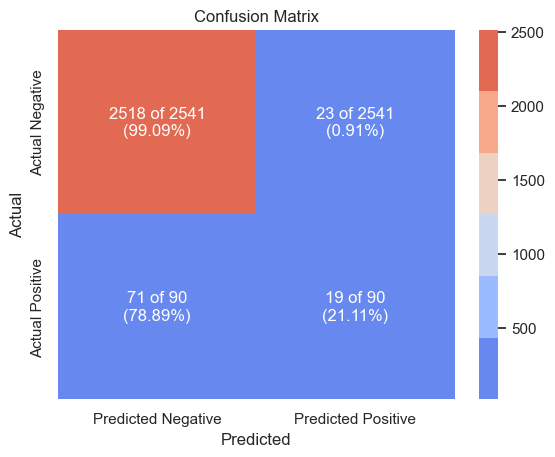

In [47]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Create a custom annotation matrix
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    row_sum = cm[i].sum()
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]} of {row_sum}\n({cm_normalized[i, j]:.2%})"

# Create a heatmap to visualize the confusion matrix
sns.heatmap(
    cm,
    annot=annotations,
    fmt="",
    cmap=sns.color_palette("coolwarm", as_cmap=False),
    xticklabels=["Predicted Negative", "Predicted Positive"],
    yticklabels=["Actual Negative", "Actual Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Unfortunately, there were no significant improvements in the model's performance after removing the customers with less than 24 months of data.

This suggests that the model's limitations are not solely due to the observation window but may be influenced by other factors such as feature selection, class imbalance, or model complexity.